### Dataset: training, validation and test 


In [32]:
import pandas as pd
import numpy as np

from sklearn import svm
from sklearn.svm import SVR
from sklearn import tree, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import time

import warnings
warnings.filterwarnings("ignore")

### Pre-process dataset
crime_prep.csv contains many missing data in column 2 (county) and 3 (community). 
For missing data:
1) if it is missing at random, we can drop the data;
2) if it is missing not at random (e.g., depend on other variables), we can use imputation to reduce bias.

k-fold CV (cross-validation) is used to reduce the risk of overfitting;
imputation is used to fill missing data (using mean value)

In [4]:
start_time = time.time()
df_prep = pd.read_csv('crime_prep.csv')
print("--- %s seconds ---" % (time.time() - start_time))
#df_prep.shape

# Remove non predictive attributes, such as state, county, community, communitynames, fold
df_prep = df_prep.drop(['v_cont_0', 'v_cat_0', 'v_cat_1', 'v_cat_2', 'v_cat_3'], axis=1)

# Use impute function to fill the missing values (NaN)
# Missing value is filled with mean of the column data
df_impute = df_prep.copy()
impute = Imputer(missing_values="NaN", strategy='mean', axis=0)

# Fit the dataframe into imputer
impute = impute.fit(df_prep)
# Fit the new values into df and transformed
df_prep = impute.transform(df_impute)

# Convert to dataframe and add columns
df = pd.DataFrame(df_prep)
df.columns = df_impute.columns 
#df

# Build features and target dataframe
features = df.drop(["target"], axis=1)
target = pd.DataFrame(df, columns=["target"])

##############################
# Config for feature selection
##############################
KEEP_FEATURES = 10

##############################
# Config for CV
##############################
cv_count = 10

--- 0.06269383430480957 seconds ---


## Feature Selection
1. Filter Method, e.g., pearson correlation
2. Wrapper Method
    1) backward elimination: feed all the possible features to the model at first and iteratively remove the worst performing features one by one till the overall performance of the model comes in acceptable range.
    2) recursive feature elimination: recursively removing attributes and building a model on those attributes that remain.
3. Embedded Method

### Feature Importance: Decision Tree 

In [66]:
DT = tree.DecisionTreeRegressor()
DT = DT.fit(features, target)

DT_predict = DT.predict(features)
scores = cross_val_score(DT, features, target, cv=cv_count)
print("cross validation score: ", scores)
print("Accuracy: %0.2f(+/- %0.2f)"%(scores.mean(), scores.std()*2))

#features_new = zip(features.columns, (SelectKBest(f_regression, k=5).fit_transform(features, target)))
importantFeatures = sorted(zip(features.columns, DT.feature_importances_), key=lambda x: x[1], reverse=True)

# fit, we can choose f_regression OR mutual_info_regression, we can test both and see the result
importantFeatures[:KEEP_FEATURES]
df_DT=pd.DataFrame(DT.feature_importances_, columns = ["Importance"], index = features.columns).sort_values(['Importance'], ascending = False)[:KEEP_FEATURES]
print(df_DT)
# plt.figure()
# df_DT.plot.bar()
# plt.xlabel('Top '+str(KEEP_FEATURES)+' Predictive Features')
# plt.ylabel('Feature Coefficients')
# plt.show()

#            Importance
# v_cont_55    0.426132
# v_cont_49    0.077768
# v_cont_48    0.057545
# v_cont_8     0.031945
# v_cont_95    0.021462
# v_cont_54    0.020235
# v_cont_97    0.013746
# v_cont_20    0.012954
# v_cont_45    0.010059
# v_cont_58    0.009453

cross validation score:  [0.28796166 0.22461444 0.31569316 0.22610981 0.25105404 0.27017045
 0.34814943 0.1689841  0.30606431 0.25432409]
Accuracy: 0.27(+/- 0.10)
           Importance
v_cont_55    0.426132
v_cont_49    0.077768
v_cont_48    0.057545
v_cont_8     0.031945
v_cont_95    0.021462
v_cont_54    0.020235
v_cont_97    0.013746
v_cont_20    0.012954
v_cont_45    0.010059
v_cont_58    0.009453


### Feature Selection: Random Forest

In [167]:
regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
regr = regr.fit(features, target)

regr_predict = regr.predict(features)
scores = cross_val_score(regr, features, target, cv=cv_count)
print("cross validation score: ", scores)
print("Accuracy: %0.2f(+/- %0.2f)"%(scores.mean(), scores.std()*2))

#features_new = zip(features.columns, (SelectKBest(f_regression, k=5).fit_transform(features, target)))
importantFeatures = sorted(zip(features.columns, regr.feature_importances_), key=lambda x: x[1], reverse=True)

# fit, we can choose f_regression OR mutual_info_regression, we can test both and see the result
importantFeatures[:KEEP_FEATURES]
df_randomforest=pd.DataFrame(regr.feature_importances_, columns = ["Importance"], index = features.columns).sort_values(['Importance'], ascending = False)[:KEEP_FEATURES]
print(df_randomforest)
# plt.figure()
# df_DT.plot.bar()
# plt.xlabel('Top '+str(KEEP_FEATURES)+' Predictive Features')
# plt.ylabel('Feature Coefficients')
# plt.show()

# cross validation score:  [0.47337836 0.50818785 0.51256966 0.59539048 0.62643043 0.63831034
#  0.56894194 0.57246909 0.57869827 0.55105908]
# Accuracy: 0.56(+/- 0.10)
#             Importance
# v_cont_55     0.683332
# v_cont_49     0.238437
# v_cont_48     0.054646
# v_cont_8      0.012732
# v_cont_54     0.007896
# v_cont_79     0.001070
# v_cont_106    0.001061
# v_cont_111    0.000826
# v_cont_5      0.000000
# v_cont_86     0.000000

cross validation score:  [0.47337836 0.50818785 0.51256966 0.59539048 0.62643043 0.63831034
 0.56894194 0.57246909 0.57869827 0.55105908]
Accuracy: 0.56(+/- 0.10)
            Importance
v_cont_55     0.683332
v_cont_49     0.238437
v_cont_48     0.054646
v_cont_8      0.012732
v_cont_54     0.007896
v_cont_79     0.001070
v_cont_106    0.001061
v_cont_111    0.000826
v_cont_5      0.000000
v_cont_86     0.000000


### Feature Selection: SelectKBest

<Figure size 432x288 with 0 Axes>

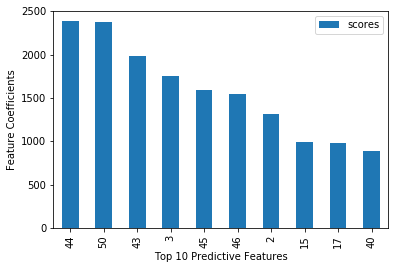

In [70]:
# # fit, we can choose f_regression OR mutual_info_regression, we can test both and see the result
importantFeatures = SelectKBest(f_regression, k=KEEP_FEATURES)
importantFeatures.fit(features,target)

X_new = importantFeatures.transform(features)
#print(importantFeatures.get_support(indices=True))

df_SB=pd.DataFrame(dict(feature_names= features.columns , scores = importantFeatures.scores_))\
    .sort_values('scores',ascending = False)[:KEEP_FEATURES]
plt.figure()
df_SB.plot.bar()
plt.xlabel('Top '+str(KEEP_FEATURES)+' Predictive Features')
plt.ylabel('Feature Coefficients')
plt.show()

# 	feature_names	scores
# 44	v_cont_49	2388.618688
# 50	v_cont_55	2381.983200
# 43	v_cont_48	1987.057310
# 3	v_cont_8	1758.772273
# 45	v_cont_50	1588.379860
# 46	v_cont_51	1550.531636
# 2	v_cont_7	1319.686433
# 15	v_cont_20	990.700975
# 17	v_cont_22	982.200468
# 40	v_cont_45	891.494025

### Feature Selection: Recursive Feature Elimination (RFE)


In [71]:
# create a base classifier used to evaluate a subset of attributes
estimator = SVR(kernel='linear')
# create the RFE model and select X attributes, X=KEEP_FATURES
selector = RFE(estimator, KEEP_FEATURES, step=1)

# Without specifing the number of features, RFECV finds the optimal 
# number of features
#selector = RFECV(estimator, step=1, cv=5)

# Fit the model
selector = selector.fit(features, target)

# summarize the selection of the attributes
#print(selector.support_)
#print(selector.ranking_)
rfe_features = sorted(zip(features.columns, selector.ranking_), key=lambda x: x[1], reverse=False)[:KEEP_FEATURES]
print(rfe_features)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False  True  True False False False False False False False False
 False False False False False False False False  True False False  True
 False False False False False False False  True  True False  True False
 False  True False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[104  66  22 105  84  96  32  26  57 109  74  76  18   3  70  25  44  97
  43  17  72  42  65  79 103  59  64  10  36  45  50  98 111   2  52  60
  77  49  15  27  28  48  83  33   1  73  82  41  24   9   1   1  93 106
  91  90  92  11  12  30  35   4  54 

## Summary:
#### Most important features by different methods
selectKBest
49,55,48,8,50,51,7,20,22,45

Decision Tree importance
55,49,48,8,95,54,97,20,45,58

RFE
49,55,56,73,76,84,85,87,90,95

We can see that 49/55 ranked highest importance for all the 3 methods, mostly highly correlated with the target.

### Dimensionality Reduction: PCA
LDA ("supervised"): use information of classes to find new features to maximize its separability
PCA ("unsupervised"): use variance of each feature to maximize its separability; it actually constructs a new set of features

PCA is concerned with covariance of predictor matrix X (input features); in regression, we also need to concern with the covariance of X (features) and y (target). 

PCR, PLS

In [59]:
pca = PCA(n_components=5)
pca.fit(features)  
print(pca.explained_variance_ratio_)  
print(pca.singular_values_)  

[0.25854019 0.18166128 0.07971167 0.06863376 0.0447857 ]
[46.24373896 38.76324226 25.67733016 23.82636609 19.24680277]


### Prediction: SVM
*NOTE: GridSearchCV can be used to optimize each of the following models, to make it simple and accelerate the training speed for demo purpose, GridSearchCV is not implemented here

In [123]:
# Default SVR is kernel=rbf
# <bound method BaseEstimator.get_params of SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
#   gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
#   tol=0.001, verbose=False)>
svr_base    = svm.SVR()
# svr_rbf     = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
# svr_lin     = svm.SVR(kernel='linear', C=100, gamma='auto')
# svr_poly    = svm.SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)
print("SVR params:", svr_base.get_params)

regressor = svr_base
scores_fullfeature = cross_val_score(regressor, features, target, cv=cv_count)
print("cross validation score: ", scores_fullfeature)
print("Accuracy: %0.2f(+/- %0.2f)"%(scores_fullfeature.mean(), scores_fullfeature.std()*2))

# cross validation score:  [0.6105303  0.64428898 0.69607301 0.67623805 0.64421084]
# Accuracy: 0.65(+/- 0.06)

# ****************************************************************
# Make cross-validation predictions
# ****************************************************************
predictions = cross_val_predict(regressor, features, target, cv=cv_count)
# plt.scatter(target, predictions, edgecolors=(0,0,0))
# plt.plot([min(target),max(target)], [min(target), max(target)], 'k--', lw=4)
# plt.xlabel("Measured")
# plt.ylabel("Predicted")
# plt.show()

accuracy = metrics.r2_score(target, predictions)
print("Cross-predicted Accuracy:", accuracy)

# cross validation score:  [0.6105303  0.64428898 0.69607301 0.67623805 0.64421084]
# Accuracy: 0.65(+/- 0.06)
# Cross-predicted Accuracy: 0.6554434180226716

SVR params: <bound method BaseEstimator.get_params of SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)>
cross validation score:  [0.6105303  0.64428898 0.69607301 0.67623805 0.64421084]
Accuracy: 0.65(+/- 0.06)
Cross-predicted Accuracy: 0.6554434180226716


#### Prediction with selected features: SVM

In [169]:
features_rfe    = features[['v_cont_49','v_cont_55','v_cont_56', 'v_cont_73', 'v_cont_76','v_cont_84','v_cont_85','v_cont_87','v_cont_90','v_cont_95']]
features_sb     = features[['v_cont_49','v_cont_55','v_cont_48','v_cont_8','v_cont_50','v_cont_51','v_cont_7','v_cont_20','v_cont_22','v_cont_45']]
features_dt     = features[['v_cont_55', 'v_cont_49', 'v_cont_48', 'v_cont_8', 'v_cont_95', 'v_cont_54', 'v_cont_97', 'v_cont_20', 'v_cont_45', 'v_cont_58']]
features_forest = features[['v_cont_55', 'v_cont_49', 'v_cont_48', 'v_cont_8','v_cont_54','v_cont_79','v_cont_106','v_cont_111']]
target_new = target

regressor = svr_base

feature_select = features_rfe
scores_selectfeature = cross_val_score(regressor, feature_select, target, cv=cv_count)
print("cross validation score: ", scores_selectfeature)
print("Accuracy: %0.2f(+/- %0.2f)"%(scores_selectfeature.mean(), scores_selectfeature.std()*2))

predictions = cross_val_predict(regressor, feature_select, target, cv=cv_count)
accuracy = metrics.r2_score(target, predictions)
print("Cross-predicted Accuracy:", accuracy)

# cross validation score:  [0.58642208 0.62923829 0.68646175 0.66830287 0.644102  ]
# Accuracy: 0.64(+/- 0.07)
# Cross-predicted Accuracy: 0.6437637387149937

cross validation score:  [0.56415762 0.61959577 0.60232492 0.66025589 0.65215808 0.73276236
 0.68662424 0.64208606 0.65136553 0.6285674 ]
Accuracy: 0.64(+/- 0.09)
Cross-predicted Accuracy: 0.6447088310779898


#### Conclusion: accuracy with 10 selected features is close to the full feature set

### Decision Tree

In [143]:
regressor = tree.DecisionTreeRegressor()
#clf = clf.fit(features, target) # regression without CV
scores_fullfeature = cross_val_score(regressor, features, target, cv=cv_count)
print("cross validation score: ", scores_fullfeature)
print("Accuracy: %0.2f(+/- %0.2f)"%(scores_fullfeature.mean(), scores_fullfeature.std()*2))

predictions = cross_val_predict(regressor, features, target, cv=cv_count)

accuracy = metrics.r2_score(target, predictions)
print("Cross-predicted Accuracy:", accuracy)

# cross validation score:  [0.10245168 0.31361058 0.34538246 0.27211849 0.27847284]
# Accuracy: 0.26(+/- 0.17)
# Cross-predicted Accuracy: 0.26242482154656266

cross validation score:  [0.10245168 0.31361058 0.34538246 0.27211849 0.27847284]
Accuracy: 0.26(+/- 0.17)
Cross-predicted Accuracy: 0.26242482154656266


#### Prediction with selected features: Decision Tree

In [144]:
feature_select = features_dt
scores_selectfeature = cross_val_score(regressor, feature_select, target, cv=cv_count)
print("cross validation score: ", scores_selectfeature)
print("Accuracy: %0.2f(+/- %0.2f)"%(scores_selectfeature.mean(), scores_selectfeature.std()*2))

predictions = cross_val_predict(regressor, feature_select, target, cv=cv_count)
accuracy = metrics.r2_score(target, predictions)
print("Cross-predicted Accuracy:", accuracy)

cross validation score:  [0.183659   0.36247151 0.44602598 0.33832722 0.28923339]
Accuracy: 0.32(+/- 0.17)
Cross-predicted Accuracy: 0.3526285859550219


### KNN

In [148]:
regressor = tree.DecisionTreeRegressor()
scores_fullfeature = cross_val_score(regressor, features, target, cv=cv_count)
print("cross validation score: ", scores_fullfeature)
print("Accuracy: %0.2f(+/- %0.2f)"%(scores_fullfeature.mean(), scores_fullfeature.std()*2))

predictions = cross_val_predict(regressor, features, target, cv=cv_count)

accuracy = metrics.r2_score(target, predictions)
print("Cross-predicted Accuracy:", accuracy)


cross validation score:  [0.16437023 0.3242882  0.37168    0.2610692  0.23114422]
Accuracy: 0.27(+/- 0.14)
Cross-predicted Accuracy: 0.25443657597836744


#### Prediction with selected features: KNN

In [157]:
feature_select = features_rfe
scores_selectfeature = cross_val_score(regressor, feature_select, target, cv=cv_count)
print("cross validation score: ", scores_selectfeature)
print("Accuracy: %0.2f(+/- %0.2f)"%(scores_selectfeature.mean(), scores_selectfeature.std()*2))

predictions = cross_val_predict(regressor, feature_select, target, cv=cv_count)
accuracy = metrics.r2_score(target, predictions)
print("Cross-predicted Accuracy:", accuracy)

cross validation score:  [0.31719369 0.21411315 0.26871375 0.23131947 0.30823379 0.58348508
 0.43398389 0.25831884 0.28190832 0.10537655]
Accuracy: 0.30(+/- 0.25)
Cross-predicted Accuracy: 0.30407979704820043


### Random Forest

In [168]:
# depth of tree 2, number of trees 100
regressor = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
scores_fullfeature = cross_val_score(regressor, features, target, cv=cv_count)
print("cross validation score: ", scores_fullfeature)
print("Accuracy: %0.2f(+/- %0.2f)"%(scores_fullfeature.mean(), scores_fullfeature.std()*2))

predictions = cross_val_predict(regressor, features, target, cv=cv_count)

accuracy = metrics.r2_score(target, predictions)
print("Cross-predicted Accuracy:", accuracy)

# cross validation score:  [0.47337836 0.50818785 0.51256966 0.59539048 0.62643043 0.63831034
#  0.56894194 0.57246909 0.57869827 0.55105908]
# Accuracy: 0.56(+/- 0.10)

cross validation score:  [0.47337836 0.50818785 0.51256966 0.59539048 0.62643043 0.63831034
 0.56894194 0.57246909 0.57869827 0.55105908]
Accuracy: 0.56(+/- 0.10)
Cross-predicted Accuracy: 0.5634702626263526


#### Prediction with selected features: Random Forest

In [170]:
feature_select = features_forest
scores_selectfeature = cross_val_score(regressor, feature_select, target, cv=cv_count)
print("cross validation score: ", scores_selectfeature)
print("Accuracy: %0.2f(+/- %0.2f)"%(scores_selectfeature.mean(), scores_selectfeature.std()*2))

predictions = cross_val_predict(regressor, feature_select, target, cv=cv_count)
accuracy = metrics.r2_score(target, predictions)
print("Cross-predicted Accuracy:", accuracy)

# cross validation score:  [0.54282045 0.57425864 0.57837188 0.65034893 0.65296021 0.70227148
#  0.63478688 0.61237552 0.62364641 0.55529938]
# Accuracy: 0.61(+/- 0.09)
# Cross-predicted Accuracy: 0.6149497533541618

cross validation score:  [0.54282045 0.57425864 0.57837188 0.65034893 0.65296021 0.70227148
 0.63478688 0.61237552 0.62364641 0.55529938]
Accuracy: 0.61(+/- 0.09)
Cross-predicted Accuracy: 0.6149497533541618


### Voting Regressor

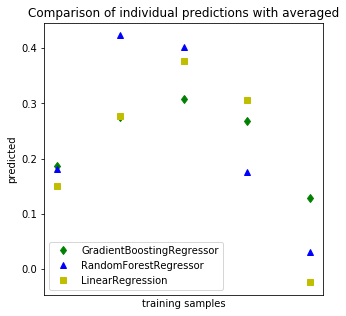

In [54]:
# Training classifier
reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)
reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
reg3 = LinearRegression()
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
reg1.fit(features, target)
reg2.fit(features, target)
reg3.fit(features, target)
ereg.fit(features, target)

xt = features[:5]

plt.figure()
plt.plot(reg1.predict(xt), 'gd', label='GradientBoostingRegressor')
plt.plot(reg2.predict(xt), 'b^', label='RandomForestRegressor')
plt.plot(reg3.predict(xt), 'ys', label='LinearRegression')
#plt.plot(ereg.predict(xt), 'r*', label='VotingRegressor')
plt.tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Comparison of individual predictions with averaged')
plt.show()

In [60]:
xt1 = features[:10]
print(ereg.predict(xt1))
print(features[:10])

   v_cont_5  v_cont_6  v_cont_7  v_cont_8  v_cont_9  v_cont_10  v_cont_11  \
0      0.19      0.33      0.02      0.90      0.12       0.17       0.34   
1      0.00      0.16      0.12      0.74      0.45       0.07       0.26   
2      0.00      0.42      0.49      0.56      0.17       0.04       0.39   
3      0.04      0.77      1.00      0.08      0.12       0.10       0.51   
4      0.01      0.55      0.02      0.95      0.09       0.05       0.38   
5      0.02      0.28      0.06      0.54      1.00       0.25       0.31   
6      0.01      0.39      0.00      0.98      0.06       0.02       0.30   
7      0.01      0.74      0.03      0.46      0.20       1.00       0.52   
8      0.03      0.34      0.20      0.84      0.02       0.00       0.38   
9      0.01      0.40      0.06      0.87      0.30       0.03       0.90   

   v_cont_12  v_cont_13  v_cont_14     ...      v_cont_117  v_cont_118  \
0       0.47       0.29       0.32     ...        0.290000        0.12   
1   

### XGBoost
* learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
* max_depth: determines how deeply each tree is allowed to grow during any boosting round.
* subsample: percentage of samples used per tree. Low value can lead to underfitting.
* colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
* n_estimators: number of trees you want to build.
* objective: determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability.

* gamma: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
* alpha: L1 regularization on leaf weights. A large value leads to more regularization.
* lambda: L2 regularization on leaf weights and is smoother than L1 regularization.


RMSE: 0.183738
49    0.142887
Name: test-rmse-mean, dtype: float64


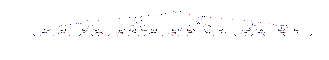

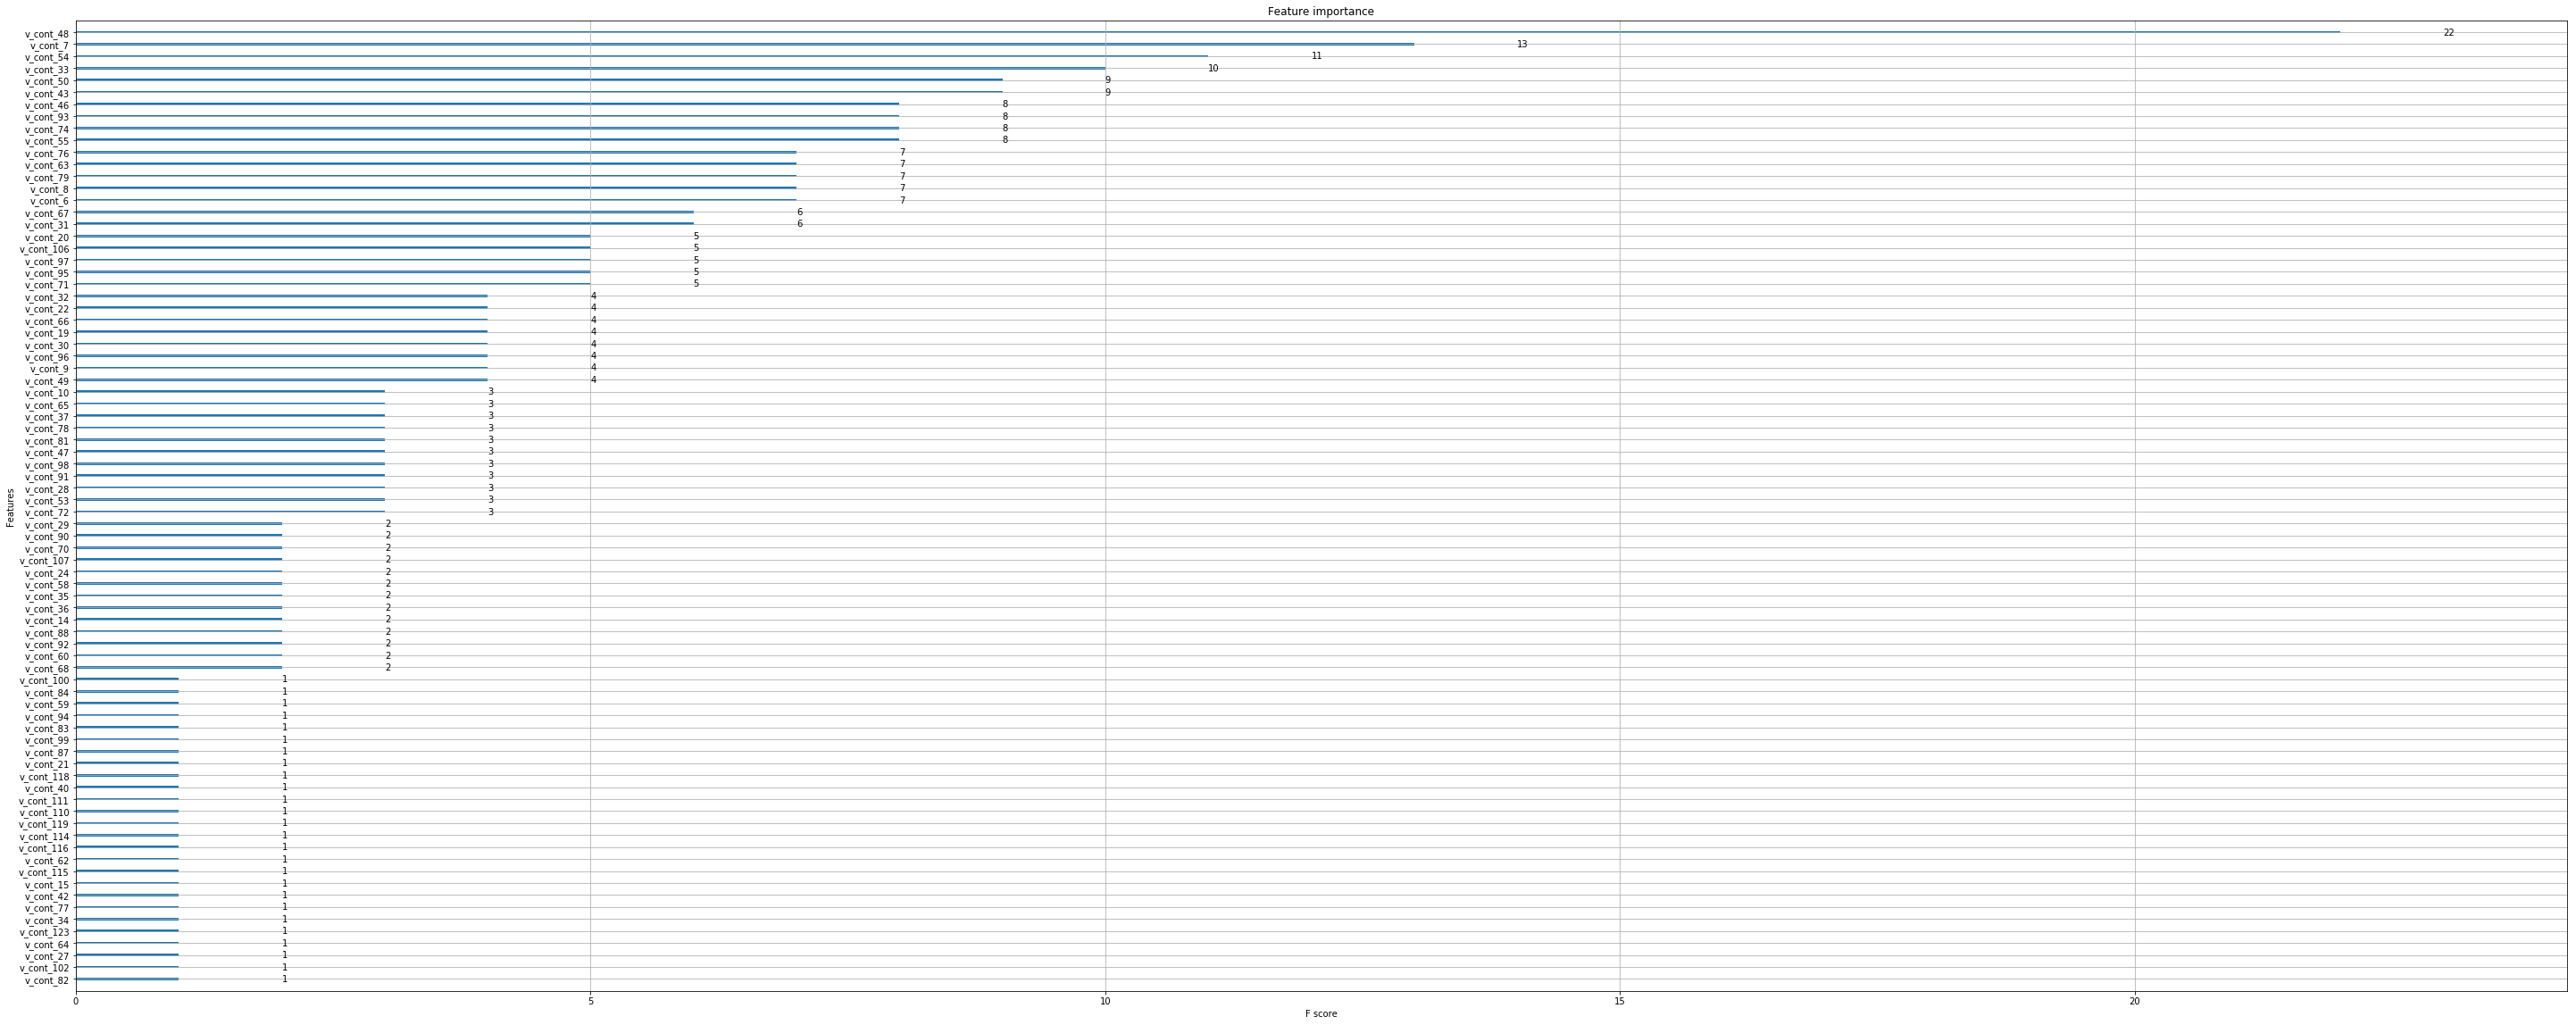

[0.0000000e+00 2.9103213e-03 3.4185417e-02 1.2699836e-01 3.4597002e-03
 5.4199360e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.6850657e-03
 9.3041975e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.8911116e-03
 1.2555349e-02 1.4218757e-03 4.2706425e-03 0.0000000e+00 1.4624668e-03
 0.0000000e+00 0.0000000e+00 1.7905445e-03 3.0093456e-03 4.0391628e-03
 5.8930647e-03 6.0798889e-03 1.3380212e-02 1.0644966e-02 1.4483555e-02
 6.0645407e-03 3.9665182e-03 4.7891210e-03 0.0000000e+00 0.0000000e+00
 7.1791355e-03 0.0000000e+00 6.0899089e-05 1.2086352e-02 0.0000000e+00
 0.0000000e+00 1.1254483e-02 3.7990394e-03 4.0866304e-02 6.4211309e-02
 2.1587698e-02 0.0000000e+00 0.0000000e+00 4.0762406e-03 9.3260802e-02
 1.5958118e-01 0.0000000e+00 0.0000000e+00 4.2860913e-03 3.9720801e-03
 6.7769699e-03 0.0000000e+00 1.6955638e-02 8.3839474e-03 7.8912023e-03
 6.0316133e-03 5.3227507e-03 9.2824809e-03 3.4442667e-03 0.0000000e+00
 1.7597189e-03 7.3924409e-03 7.7803629e-03 0.0000000e+00 7.5211199e-03
 0.000

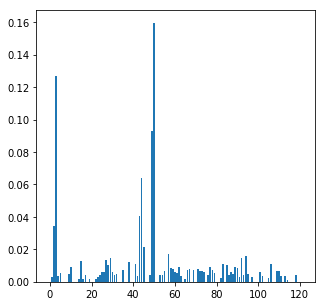

           Importance
v_cont_55    0.159581
v_cont_8     0.126998
v_cont_54    0.093261
v_cont_49    0.064211
v_cont_48    0.040866
v_cont_7     0.034185
v_cont_50    0.021588
v_cont_62    0.016956
v_cont_99    0.015684
v_cont_34    0.014484


In [63]:
# Convert dataset to dmatrix, which xgboost supports for high performance
data_dmatrix = xgb.DMatrix(data=features,label=target)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)


cv_results.head()
print((cv_results["test-rmse-mean"]).tail(1))

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 20]
plt.show()

xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

print(xg_reg.feature_importances_)
plt.bar(range(len(xg_reg.feature_importances_)), xg_reg.feature_importances_)
plt.show()

# Feature Selection
#importantFeatures[:KEEP_FEATURES]
df_xgb=pd.DataFrame(xg_reg.feature_importances_, columns = ["Importance"], index = features.columns).sort_values(['Importance'], ascending = False)[:KEEP_FEATURES]
print(df_xgb)

In [52]:
print (xg_reg)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)


In [ ]:
%reset